In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ohbemn import Solver, Region, ohpy, Orientation
from ohbemn.ohpy import wave, source

wave length: [39.01922213]
elements: 128


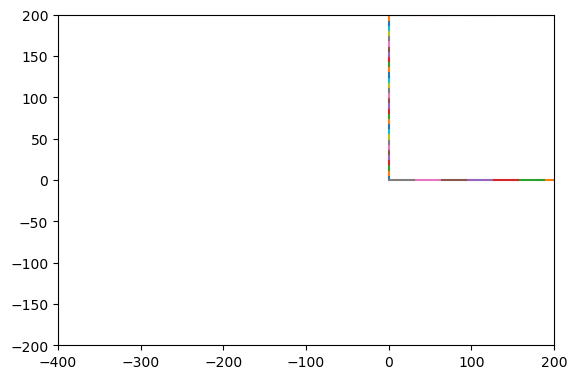

In [2]:
T = 5.   # [s]
f = 1/T
d = 40.  # [m]
c, cg, k = wave.wavec_interm(T, d)
print("wave length:", c/f)

regionp = ohpy.Region.rectangle(1000, 200, 32, 32)
region = Region(regionp.vertices, regionp._edges)

f, ax = plt.subplots()
regionp.plot(ax)
ax.set_xlim([-400, 200])
ax.set_ylim([-200, 200])
ax.set_aspect('equal')

print("elements:", region.len())

The breakwater is completely solid. So the boundary condition along its boundary is:

$\frac{\partial \phi}{\partial n} = 0$

which, since it is defined on the derivative of the velocity potential is a Neumann boundary condition.

In [23]:
bc = region.neumann_boundary_condition()


centers = region.centers()
normals = region.normals()

for i in range(region.len()):
    x = centers[i, :]
    n = normals[i, :]
    bc.f[i] = 0
    
    if x[1] < 0.01:    
        bc.beta[i] = 1.
        bc.alpha[i] = 0.
        phi = source.plane(0, k, *x)[0]
        bc.f[i] = phi
    else:
        bc.beta[i] = 0.
        bc.alpha[i] = 1.

The incoming field is a plane wave. Calculate $\phi$ and $\frac{\partial \phi}{\partial n}$ at the center of each boundary element.

In [24]:
bi = region.boundary_incidence()


for i in range(region.len()):
    x = centers[i, :]
    n = normals[i, :]

    phi = source.plane(0, k, *x)[0]
    dphidn = source.dplane(0, k, x[0], x[1], -n)[0]

    if x[0] < 0.01:
        bi.v[i] = dphidn
    else:
        #bi.phi[i] = phi
        pass

    print("Center:", x, "Normal:", n, "phi:", bi.phi[i], "dPhidn: ", bi.v[i])


Center: [0.    3.125] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [0.    9.375] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    15.625] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    21.875] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    28.125] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    34.375] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    40.625] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    46.875] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    53.125] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    59.375] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    65.625] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    71.875] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    78.125] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    84.375] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    90.625] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [ 0.    96.875] Normal: [-1. -0.] phi: 0j dPhidn:  0j
Center: [  0

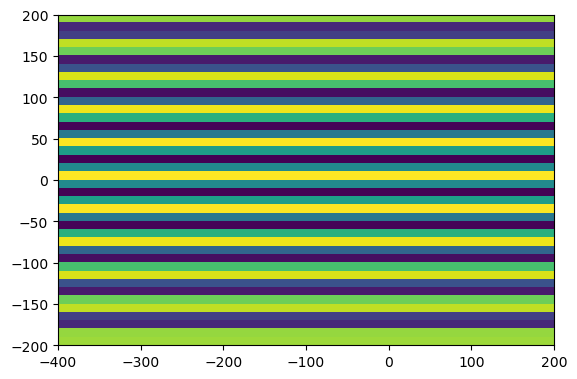

In [25]:
# Sample grid

x = np.arange(-400, 200, 10)
y = np.arange(-200, 200, 10)
xx, yy = np.meshgrid(x, y)

# Incident field without break-water
fI = source.plane(0, k, xx, yy)

f, ax = plt.subplots()
ax.set_aspect('equal')
#region.plot(ax)
ax.imshow(fI.real, origin='lower', extent=[-400, 200, -200, 200])

In [26]:
# Solve boundary.

solver = Solver(region)
boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)
print(boundary_solution)

/tmp/ipykernel_231963/1330136690.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)


In [27]:
# Solve samples in interior
x = np.arange(0, 200, 2)
y = np.arange(0, 200, 2)
xx, yy = np.meshgrid(x, y)
ep = np.vstack((xx.ravel(), yy.ravel())).T

print('Solving for exterior points:', ep.shape)
eF = boundary_solution.solve_samples(np.zeros(ep.shape[0]), ep)

Solving for exterior points: (10000, 2)


(-400.0, 200.0)

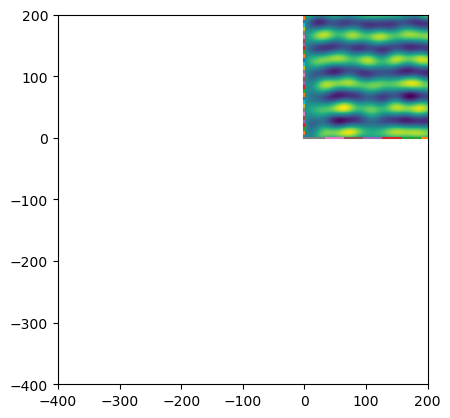

In [28]:
eFp = eF.phis.reshape(xx.shape)
f, ax = plt.subplots()
regionp.plot(ax)
ax.set_aspect('equal')
ax.imshow(eFp.real, origin='upper', extent=[0, 200, 0, 200])
ax.set_xlim(-400, 200)
ax.set_ylim(-400, 200)